In [ ]:
import pandas as pd

# Check the path to the dataset
FILE_PATH = '/kaggle/input/dataset-hate/Religion_data_English.csv'

# Load the CSV file
df = pd.read_csv(FILE_PATH)

# Display first few rows
print(df.head())


In [ ]:
!pip install transformers -q
!pip install scikit-learn -q
!pip install transformers torch sklearn matplotlib

# **Albert**

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 132/132 [00:45<00:00,  2.92it/s]


Epoch 1: Train Loss=0.5160, Val Loss=0.3026, Train Acc=0.7502, Val Acc=0.8800


Epoch 2: 100%|██████████| 132/132 [00:47<00:00,  2.80it/s]


Epoch 2: Train Loss=0.2701, Val Loss=0.2574, Train Acc=0.8911, Val Acc=0.9067


Epoch 3: 100%|██████████| 132/132 [00:49<00:00,  2.67it/s]


Epoch 3: Train Loss=0.1806, Val Loss=0.2508, Train Acc=0.9320, Val Acc=0.8900


Epoch 4: 100%|██████████| 132/132 [00:48<00:00,  2.72it/s]


Epoch 4: Train Loss=0.1655, Val Loss=0.3524, Train Acc=0.9448, Val Acc=0.8667


Epoch 5: 100%|██████████| 132/132 [00:48<00:00,  2.71it/s]


Epoch 5: Train Loss=0.0896, Val Loss=0.2924, Train Acc=0.9724, Val Acc=0.8800


Epoch 6: 100%|██████████| 132/132 [00:48<00:00,  2.71it/s]


Epoch 6: Train Loss=0.0756, Val Loss=0.3440, Train Acc=0.9743, Val Acc=0.8867


Epoch 7: 100%|██████████| 132/132 [00:48<00:00,  2.71it/s]


Epoch 7: Train Loss=0.0374, Val Loss=0.3818, Train Acc=0.9862, Val Acc=0.9067


Epoch 8: 100%|██████████| 132/132 [00:48<00:00,  2.70it/s]


Epoch 8: Train Loss=0.0367, Val Loss=0.3384, Train Acc=0.9895, Val Acc=0.9067
Early stopping triggered

Final Test Metrics:
Accuracy: 0.8985
Precision: 0.9107
Recall: 0.8833
F1-Score: 0.8968
MCC: 0.7974
MAE: 0.1015
MSE: 0.1015
RMSE: 0.3186
Cohen's Kappa: 0.7970
AUC-ROC: 0.9659
CSI: 0.8129


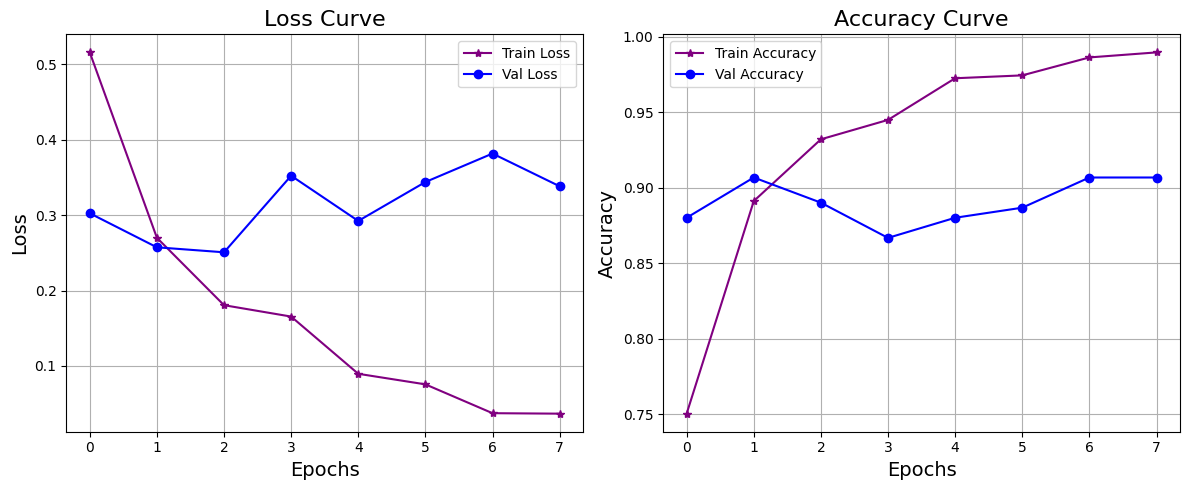

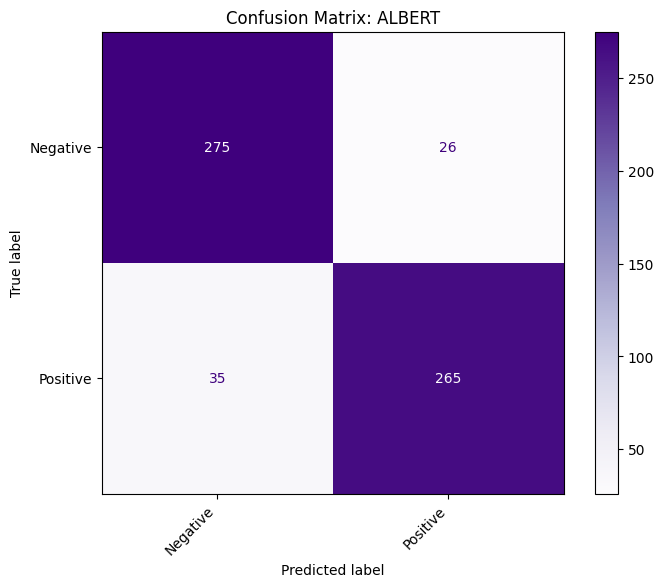

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# === 0. Load your dataset ===
df = pd.read_csv("/kaggle/input/dataset-hate/Religion_data_English.csv")

# === 1. Split data: 70% train, 10% val, 20% test ===
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'],
    test_size=0.3, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=2/3, stratify=temp_labels, random_state=42
)

# === 2. Tokenizer and Dataset ===
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # remove batch dim
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)
test_dataset = HateSpeechDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# === 3. Model, optimizer, device ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# === 4. Training Loop with Early Stopping ===
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_loss = float('inf')
patience = 5
trigger_times = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)

    model.eval()
    val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_albert.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

# === 5. Load Best Model and Evaluate on Test ===
model.load_state_dict(torch.load('best_albert.pth'))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # prob of class 1
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# === 6. Compute metrics ===
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0

print("\nFinal Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"CSI: {CSI:.4f}")

# === 7. Plot Loss and Accuracy Curves ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')
plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')
plt.plot(val_acc_list, label='Val Accuracy', color='blue', marker='o')
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/albert_training_curves.png', dpi=300)
plt.show()

# === 8. Confusion Matrix ===
labels = ['Negative', 'Positive']
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix: ALBERT', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 16})
plt.savefig('/kaggle/working/albert_confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


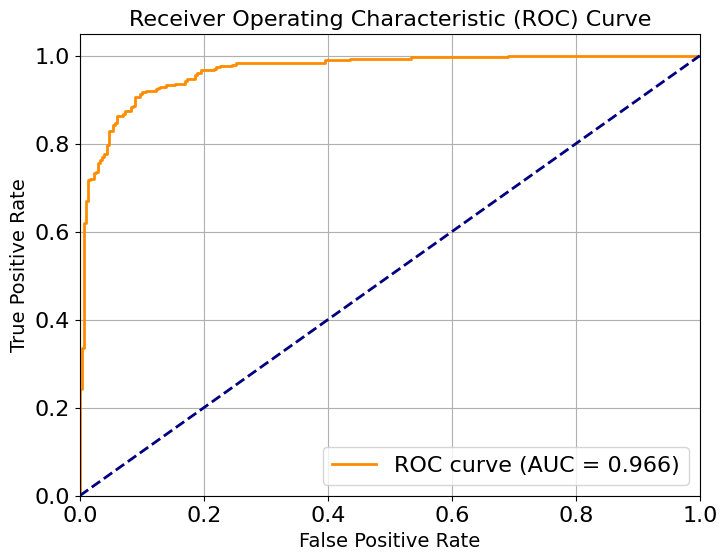

In [3]:
from sklearn.metrics import roc_curve, auc

# === 9. ROC Curve ===
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/albert_roc_curve.png', dpi=300)
plt.show()


# DistilBert

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 132/132 [00:26<00:00,  5.06it/s]


Epoch 1: Train Loss=0.3785, Val Loss=0.2500, Train Acc=0.8402, Val Acc=0.9067


Epoch 2: 100%|██████████| 132/132 [00:24<00:00,  5.33it/s]


Epoch 2: Train Loss=0.1698, Val Loss=0.2439, Train Acc=0.9367, Val Acc=0.9000


Epoch 3: 100%|██████████| 132/132 [00:24<00:00,  5.40it/s]


Epoch 3: Train Loss=0.0919, Val Loss=0.2644, Train Acc=0.9700, Val Acc=0.9000


Epoch 4: 100%|██████████| 132/132 [00:24<00:00,  5.30it/s]


Epoch 4: Train Loss=0.0421, Val Loss=0.3062, Train Acc=0.9867, Val Acc=0.9167


Epoch 5: 100%|██████████| 132/132 [00:24<00:00,  5.29it/s]


Epoch 5: Train Loss=0.0279, Val Loss=0.3530, Train Acc=0.9900, Val Acc=0.9167


Epoch 6: 100%|██████████| 132/132 [00:24<00:00,  5.33it/s]


Epoch 6: Train Loss=0.0142, Val Loss=0.3577, Train Acc=0.9957, Val Acc=0.9200


Epoch 7: 100%|██████████| 132/132 [00:24<00:00,  5.32it/s]


Epoch 7: Train Loss=0.0142, Val Loss=0.3746, Train Acc=0.9957, Val Acc=0.9100
Early stopping triggered

Final Test Metrics:
Accuracy: 0.9168
Precision: 0.8882
Recall: 0.9533
F1-Score: 0.9196
MCC: 0.8359
MAE: 0.0832
MSE: 0.0832
RMSE: 0.2884
Cohen's Kappa: 0.8336
AUC-ROC: 0.9805
CSI: 0.8512


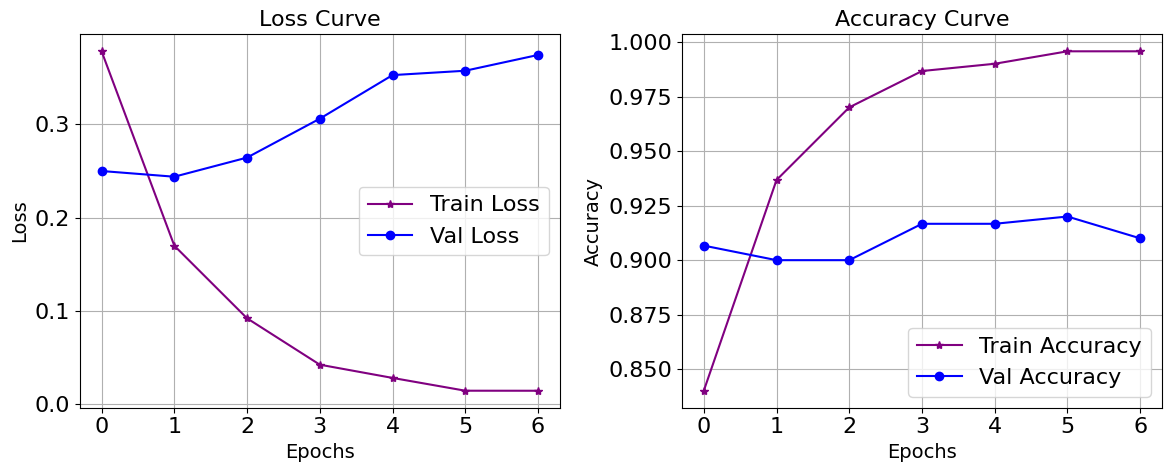

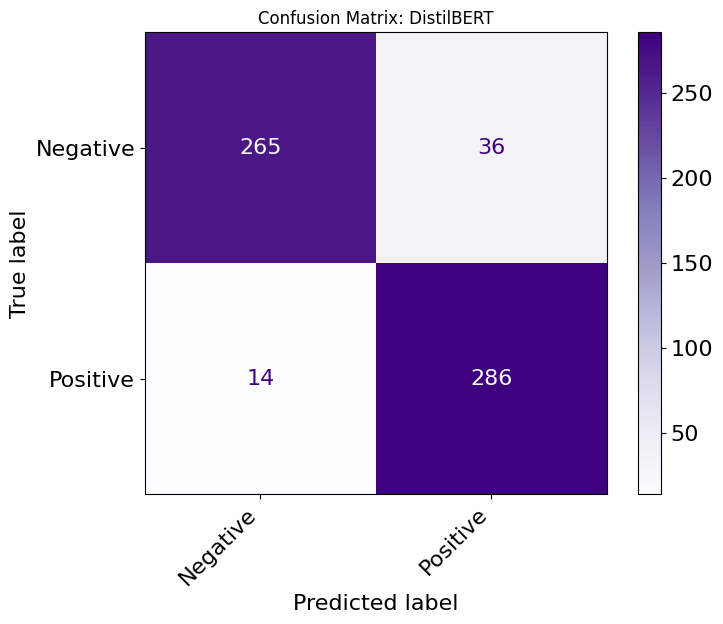

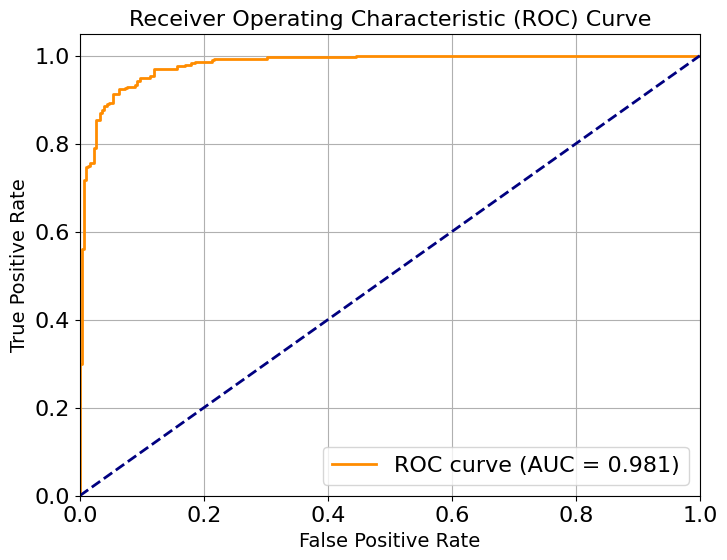

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# === 0. Load dataset ===
df = pd.read_csv("/kaggle/input/dataset-hate/Religion_data_English.csv")

# === 1. Split data: 70% train, 10% val, 20% test ===
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'],
    test_size=0.3, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=2/3, stratify=temp_labels, random_state=42
)

# === 2. Tokenizer and Dataset ===
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)
test_dataset = HateSpeechDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# === 3. Model, optimizer, device ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# === 4. Training Loop with Early Stopping ===
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_loss = float('inf')
patience = 5
trigger_times = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)

    model.eval()
    val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_distilbert.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

# === 5. Load best model and evaluate ===
model.load_state_dict(torch.load('best_distilbert.pth'))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# === 6. Metrics ===
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0

print("\nFinal Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"CSI: {CSI:.4f}")

# === 7. Plot loss and accuracy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')
plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')
plt.plot(val_acc_list, label='Val Accuracy', color='blue', marker='o')
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/distilbert_training_curves.png', dpi=300)
plt.show()

# === 8. Confusion Matrix ===
labels_names = ['Negative', 'Positive']
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix: DistilBERT', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 16})
plt.savefig('/kaggle/working/distilbert_confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# === 9. ROC Curve ===
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/distilbert_roc_curve.png', dpi=300)
plt.show()


# Electra

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Epoch 1: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]


Epoch 1: Train Loss=0.4069, Val Loss=0.2401, Train Acc=0.8287, Val Acc=0.9000


Epoch 2: 100%|██████████| 132/132 [00:48<00:00,  2.74it/s]


Epoch 2: Train Loss=0.1875, Val Loss=0.2098, Train Acc=0.9377, Val Acc=0.9300


Epoch 3: 100%|██████████| 132/132 [00:48<00:00,  2.70it/s]


Epoch 3: Train Loss=0.1050, Val Loss=0.1939, Train Acc=0.9672, Val Acc=0.9367


Epoch 4: 100%|██████████| 132/132 [00:48<00:00,  2.72it/s]


Epoch 4: Train Loss=0.0687, Val Loss=0.2636, Train Acc=0.9814, Val Acc=0.9233


Epoch 5: 100%|██████████| 132/132 [00:48<00:00,  2.71it/s]


Epoch 5: Train Loss=0.1734, Val Loss=0.3077, Train Acc=0.9125, Val Acc=0.8400


Epoch 6: 100%|██████████| 132/132 [00:48<00:00,  2.72it/s]


Epoch 6: Train Loss=0.1020, Val Loss=0.2793, Train Acc=0.9500, Val Acc=0.9167


Epoch 7: 100%|██████████| 132/132 [00:48<00:00,  2.72it/s]


Epoch 7: Train Loss=0.0564, Val Loss=0.2583, Train Acc=0.9753, Val Acc=0.9267


Epoch 8: 100%|██████████| 132/132 [00:48<00:00,  2.72it/s]


Epoch 8: Train Loss=0.0386, Val Loss=0.3047, Train Acc=0.9872, Val Acc=0.9333
Early stopping triggered

Final Test Metrics:
Accuracy: 0.9151
Precision: 0.9082
Recall: 0.9233
F1-Score: 0.9157
MCC: 0.8304
MAE: 0.0849
MSE: 0.0849
RMSE: 0.2913
Cohen's Kappa: 0.8303
AUC-ROC: 0.9746
CSI: 0.8445


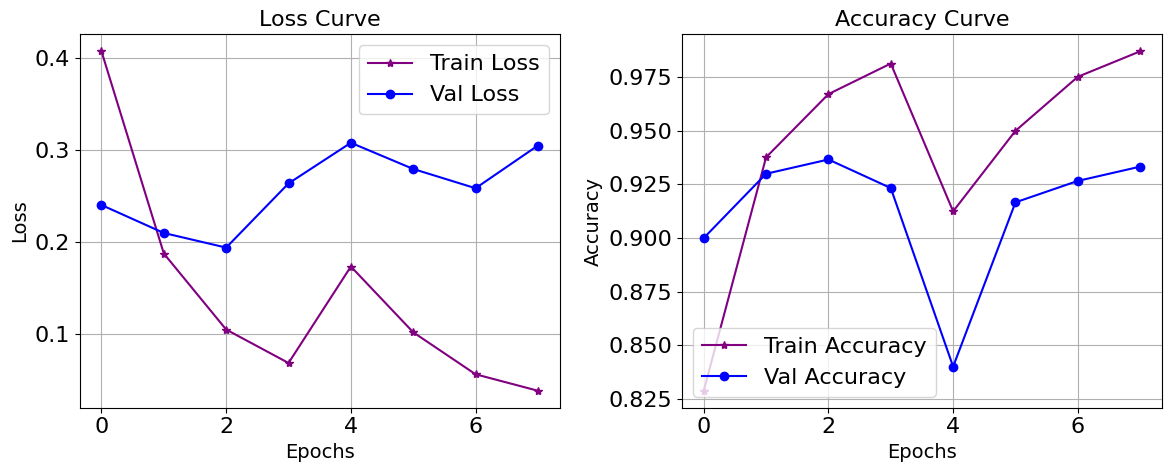

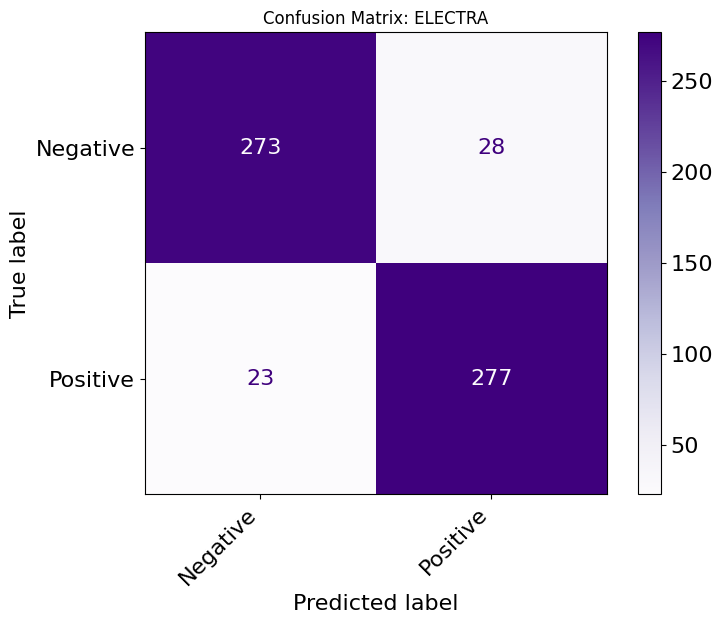

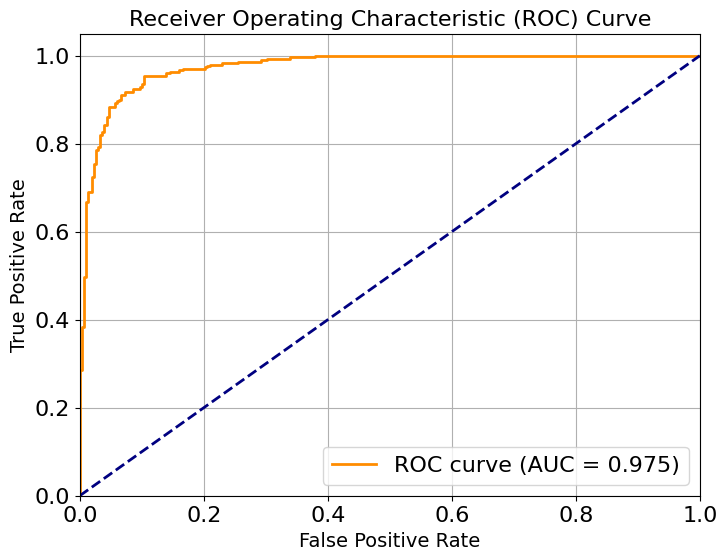

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_recall_fscore_support, matthews_corrcoef,
    mean_absolute_error, mean_squared_error,
    cohen_kappa_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# === 0. Load dataset ===
df = pd.read_csv("/kaggle/input/dataset-hate/Religion_data_English.csv")

# === 1. Split data: 70% train, 10% val, 20% test ===
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'],
    test_size=0.3, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=2/3, stratify=temp_labels, random_state=42
)

# === 2. Tokenizer and Dataset ===
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)
test_dataset = HateSpeechDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# === 3. Model, optimizer, device ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# === 4. Training Loop with Early Stopping ===
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

best_val_loss = float('inf')
patience = 5
trigger_times = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / len(train_dataset)

    model.eval()
    val_loss = 0
    correct_val = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val / len(val_dataset)

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_electra.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

# === 5. Load best model and evaluate ===
model.load_state_dict(torch.load('best_electra.pth'))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# === 6. Metrics ===
test_acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
mcc = matthews_corrcoef(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
kappa = cohen_kappa_score(all_labels, all_preds)
auc_roc = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)
TP = cm[1,1]
FN = cm[1,0]
FP = cm[0,1]
CSI = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0

print("\nFinal Test Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"CSI: {CSI:.4f}")

# === 7. Plot loss and accuracy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss', color='purple', marker='*')
plt.plot(val_loss_list, label='Val Loss', color='blue', marker='o')
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='purple', marker='*')
plt.plot(val_acc_list, label='Val Accuracy', color='blue', marker='o')
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/electra_training_curves.png', dpi=300)
plt.show()

# === 8. Confusion Matrix ===
labels_names = ['Negative', 'Positive']
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Purples, values_format='d')
plt.title('Confusion Matrix: ELECTRA', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 16})
plt.savefig('/kaggle/working/electra_confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# === 9. ROC Curve ===
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('/kaggle/working/electra_roc_curve.png', dpi=300)
plt.show()
